In [1]:
!pip install "/Users/amaghaei/Work/openmeasurement"

Processing /Users/amaghaei/Work/openmeasurement
  Created wheel for open-measurement: filename=open_measurement-0.0.1-py3-none-any.whl size=20891 sha256=ce500c71b0387c8e3a552125c5000a48e5b4e129b27b0f618d47890a6c264c51
  Stored in directory: /private/var/folders/mw/ycv4jvm57xq4v089c5qks7kh0000gp/T/pip-ephem-wheel-cache-64bw6e23/wheels/08/4d/33/16e811e777c574047fcfbe58a8bb236d71e9b8cbb047366477
Successfully built open-measurement
  Attempting uninstall: open-measurement
    Found existing installation: open-measurement 0.0.1
    Uninstalling open-measurement-0.0.1:
      Successfully uninstalled open-measurement-0.0.1


In [2]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, uniform_filter

import matplotlib
import matplotlib.pyplot as plt

import itertools
from itertools import product

import open_measurement
from open_measurement.model import MixtureOfExponentials
from open_measurement.report import RFReport, generate_report

%matplotlib notebook

# Synthecising a society

We start by Synthecising a society of `population_size` indivituals with two media, `MEDIUM I` and `MEDIUM II`. This is done by choosing a random activity distribution function (with certain specific properties. For the below example below we choose either a mixture of exponentials or power law functions) and then we randomly generate a society of users add follow that ADF.

In [3]:
# Generation of a society for two media, MEDIUM I and MEDIUM II
population_size = 10000
media = ['MEDIUM I', 'MEDIUM II']

adf = MixtureOfExponentials.random(n_exps=6, n_dims=2).normalize()
# We generate a society randomly using a random acitivity distrbution function
society = (
    adf
    .generate_virtual_society(population_size=population_size, 
                              media_cols=media, 
                              id_col="user_id", 
                              mode="random")
)

society.dataframe.head()

/Users/amaghaei/Work/openmeasurement/open_measurement/model/nonsimple.py:60: UserWarning: The amplitudes are not normalized, normalizing them ...
  warnings.warn("The amplitudes are not normalized, normalizing them ...")


,user_id,MEDIUM I,MEDIUM II
0,0,0.751831,0.017815
1,1,1.566281,0.124102
2,2,0.344134,0.455298
3,3,0.064431,0.073372
4,4,0.076566,0.167124


In [4]:
society.dataframe

,user_id,MEDIUM I,MEDIUM II
0,0,0.751831,0.017815
1,1,1.566281,0.124102
2,2,0.344134,0.455298
3,3,0.064431,0.073372
4,4,0.076566,0.167124
...,...,...,...
9995,9995,0.061291,0.001965
9996,9996,0.012142,0.770474
9997,9997,0.254314,0.011012
9998,9998,0.010750,0.535104


In [5]:
# simulate a campaign with 400% on and 800% in each medium
grps = [4 * population_size, 8 * population_size]
impressions = society.simulate_impressions(grps)

impressions

,user_id,media
0,8559,MEDIUM I
1,9826,MEDIUM I
2,5195,MEDIUM I
3,4759,MEDIUM I
4,9989,MEDIUM I
...,...,...
79995,3850,MEDIUM II
79996,1699,MEDIUM II
79997,1439,MEDIUM II
79998,7298,MEDIUM II


In [25]:
def plot_2d_reach(rf_data, dim_cols, ax=None) :
    if ax is None:
        fig, ax = plt.subplots()

    freq_label_jump = 2
    tickrange = range(0, 21, freq_label_jump)
    ticklabels = [str(i) for i in range(0, 21, freq_label_jump)]
    ticklabels[-1] = ticklabels[-1] + "+"

    im = ax.imshow(rf_data,
                   norm=matplotlib.colors.LogNorm(),
                   vmin=1,
                   vmax=2.e3,
                   origin="lower"
                  )
    ax.set_ylabel(dim_cols[0])
    ax.set_xlabel(dim_cols[1])

    ax.set_xticks(tickrange)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(tickrange)
    ax.set_yticklabels(ticklabels)

    plt.gcf().colorbar(im, ax=ax)
    
    return ax

<IPython.core.display.Javascript object>


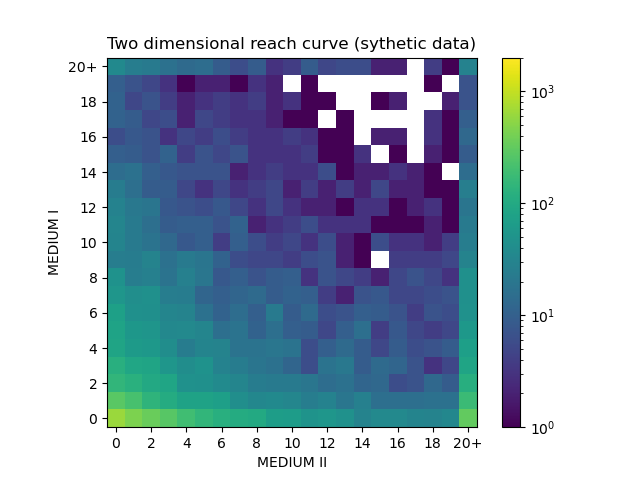

Text(0.5, 1.0, 'Two dimensional reach curve (sythetic data)')

In [31]:
report = generate_report(impressions, population_size=population_size, max_freq=20, id_col="user_id")

# plot report
fig, ax = plt.subplots()
plot_2d_reach(report.pivot_to_dim_cols().values, dim_cols=media, ax=ax)
ax.set_title("Two dimensional reach curve (sythetic data)")

# Training the activity distribution function

We now  train the activity distribution function (ADF) from the cross measurement report. The ADF is a distribution that explains the exposure berhavior of society. The `ftrunc_reach` method can calculate (predict) the multidimensional reach curve from a given ADF. For a detailed description of how it works, look at the "mathematical foundations of VID modeling" page in the documentation.

Note that ADF prediction is a smooth function compared to the noisy reality (and later on noisy VID)

[0.3231247559793468, 0.3197674994822737, 0.19022915674808488, 0.12754653474111502, 0.02735814426494286, 0.01197390878423676, 9.706279092781877, 1.4701076767172205, 8.339733055081219, 8.840804904863367, 8.50685936982821, 9.433161666937531, 0.26216668464428605, 4.170460054027317, 8.799619256012624, 7.129620144612964, 3.9868102473754696, 6.153913725197347]
([1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])


<IPython.core.display.Javascript object>


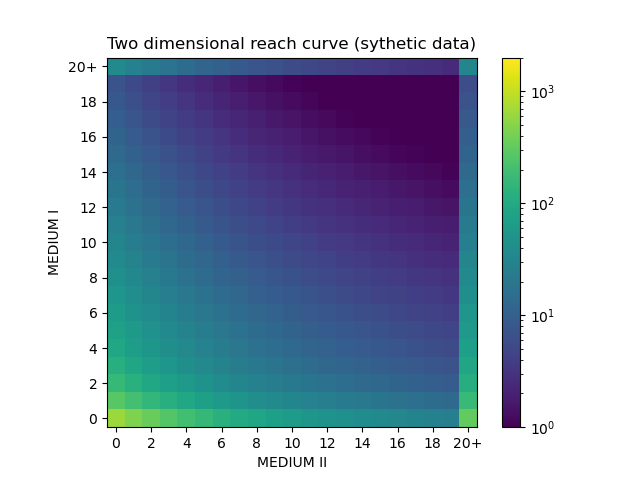

Text(0.5, 1.0, 'Two dimensional reach curve (sythetic data)')

In [33]:
adf = MixtureOfExponentials.random(n_exps=6, n_dims=2, rng=np.random.default_rng(1911))
adf.train(report)

# plot report
fig, ax = plt.subplots()
model_data = adf.ftrunc_reach(report.gr_values, max_freq=20).reshape([21, 21]) * population_size
plot_2d_reach(model_data, dim_cols=media, ax=ax)
ax.set_title("Two dimensional reach curve (sythetic data)")

In [34]:
# checking the normalization of the acitivity function on each dimension
print(
    np.sum(adf.amplitudes * adf.parameters[0::2]),
    np.sum(adf.amplitudes * adf.parameters[1::2])
)

0.9809953436507636 0.9801677326825053


In [35]:
np.reshape(adf.parameters, [-1, 2])

array([[1.31933224, 0.31497707],
       [1.36804306, 1.65711566],
       [1.38994805, 1.57275706],
       [0.09416006, 0.26278871],
       [1.39627721, 1.55380412],
       [0.09561413, 1.51260907]])

In [36]:
virtual_society = adf.generate_virtual_society(
    population_size=population_size, 
    media_cols=media, 
    id_col="vid", 
    mode="uniform"
)


virtual_society.dataframe

/Users/amaghaei/Work/openmeasurement/open_measurement/model/nonsimple.py:60: UserWarning: The amplitudes are not normalized, normalizing them ...
  warnings.warn("The amplitudes are not normalized, normalizing them ...")


,vid,MEDIUM I,MEDIUM II
0,0,0.002932,0.004339
1,1,0.002932,0.008741
2,2,0.002932,0.013207
3,3,0.002932,0.017738
4,4,0.002932,0.022337
...,...,...,...
9995,9995,6.037871,4.093078
9996,9996,6.037871,4.466954
9997,9997,6.037871,4.949081
9998,9998,6.037871,5.628789


# The multidimensional activity distribution of the society vs virtual society
Here we demonstrate at the activity distribution for a society compared to the activity distribution of the virtual society. It is obvious that while the two are following the same aggregate pattern, they are completely different societies. The most important point here is that while the activity of a normal society looks like a random distribution, we pick the virtual society to follow a specific uniform pattern that still follows the aggregate strucutre of the original society.

<IPython.core.display.Javascript object>


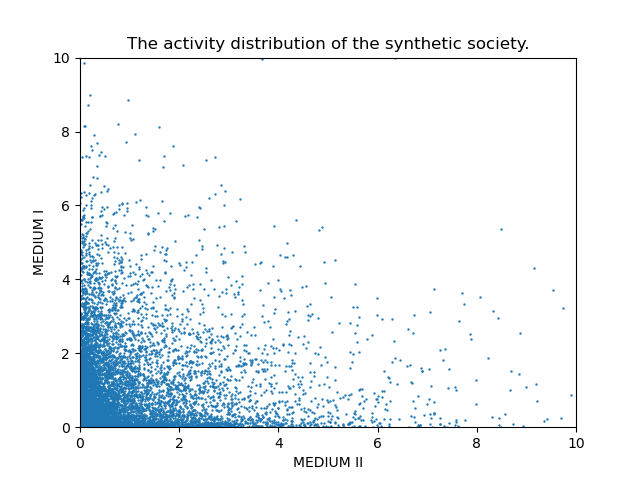

Text(0.5, 1.0, 'The activity distribution of the synthetic society.')

In [37]:
fig, ax = plt.subplots()
society.dataframe.plot(x='MEDIUM II', y='MEDIUM I', kind='scatter', style='o', s=0.5, ax=ax)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title("The activity distribution of the synthetic society.")

<IPython.core.display.Javascript object>


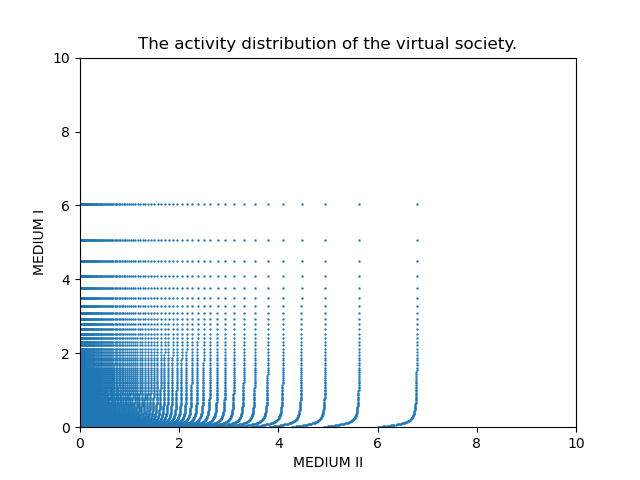

Text(0.5, 1.0, 'The activity distribution of the virtual society.')

In [38]:
fig, ax = plt.subplots()
virtual_society.dataframe.plot(x='MEDIUM II', y='MEDIUM I', kind='scatter', s=0.5, ax=ax)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title("The activity distribution of the virtual society.")

impressions

In [39]:
vid_impressions = virtual_society.assign_impressions(impressions)

In [40]:
impressions

,user_id,media,probability,vid
0,8559,MEDIUM I,0.217998,6746
1,9826,MEDIUM I,0.269971,7263
2,5195,MEDIUM I,0.460063,8309
3,4759,MEDIUM I,0.639397,9171
4,9989,MEDIUM I,0.862189,9785
...,...,...,...,...
79995,3850,MEDIUM II,0.234717,6467
79996,1699,MEDIUM II,0.187393,1667
79997,1439,MEDIUM II,0.862388,6497
79998,7298,MEDIUM II,0.553020,3488


# Generate the VID report

We will now make a report from the vid impressions and plot it to see how the the measruement campares with the measurement of the original society ...

<IPython.core.display.Javascript object>


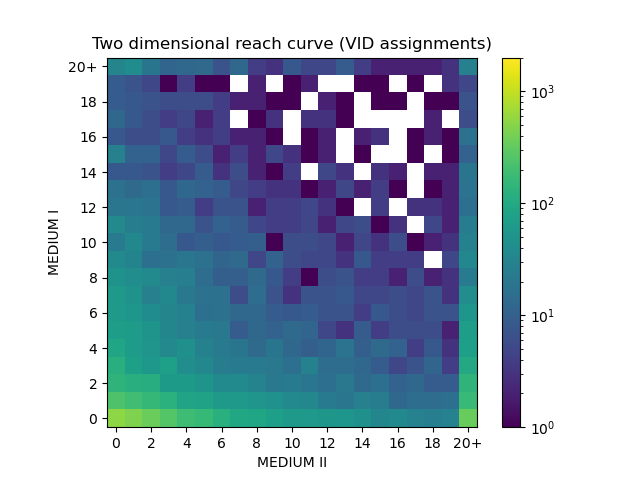

Text(0.5, 1.0, 'Two dimensional reach curve (VID assignments)')

In [42]:
vid_report = generate_report(impressions, population_size=population_size, max_freq=20, id_col="vid")

# plot report
fig, ax = plt.subplots()
plot_2d_reach(vid_report.pivot_to_dim_cols().values, dim_cols=media, ax=ax)
ax.set_title("Two dimensional reach curve (VID assignments)")

# Errors in the report generated by VID vs the original cross screen report
Below we inverstigate the multidimensional frequency reach surface error between the mneasurement report of the original society vs the report that was generated by the VID assigned to the impression table.

The first plot is the relative error between mutlidimensional reach over the range of 0 to 20+ frequencies. The error shows a noisey result specifically for higher frequencies. We also plot the error with a gaussian filter to show that the error is relatively small across the multi-frequency reach curve.

However, the important factors such as reach, overlap reach, and exclusive reach is shown to have a very reasonable accuracy, so the modelling correctly predicts the parameters of interest to ad campaign measurement.


<ipython-input-16-e32148488a55>:2: RuntimeWarning: divide by zero encountered in true_divide
  error = 100*(vid_report.pivot_to_dim_cols().values - report.pivot_to_dim_cols().values)/report.pivot_to_dim_cols().values
<ipython-input-16-e32148488a55>:2: RuntimeWarning: invalid value encountered in true_divide
  error = 100*(vid_report.pivot_to_dim_cols().values - report.pivot_to_dim_cols().values)/report.pivot_to_dim_cols().values


<IPython.core.display.Javascript object>


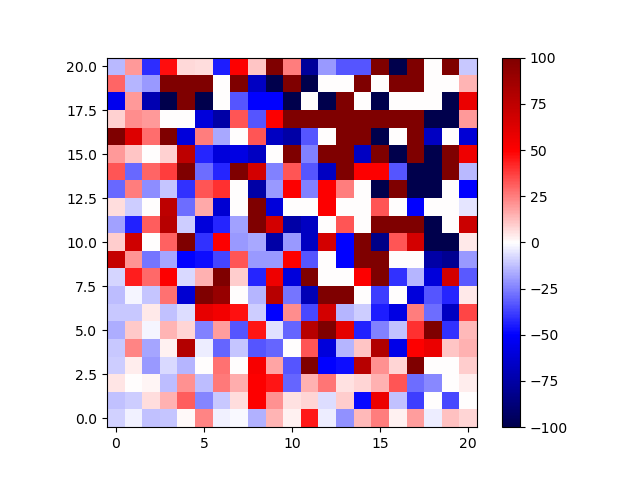

In [16]:
# Error across the multidimensional frequency domain
error = 100*(vid_report.pivot_to_dim_cols().values - report.pivot_to_dim_cols().values)/report.pivot_to_dim_cols().values

# clean up for the error matrix
error = np.nan_to_num(error, nan=0, posinf=100, neginf=-100)
error[error > 100] = 100
error[error < -100] = -100


fig, ax = plt.subplots()
im = ax.imshow(error,
           vmin=100,
           vmax=-100,
           cmap='seismic',
           origin="lower")
fig.colorbar(im, ax=ax)

<IPython.core.display.Javascript object>


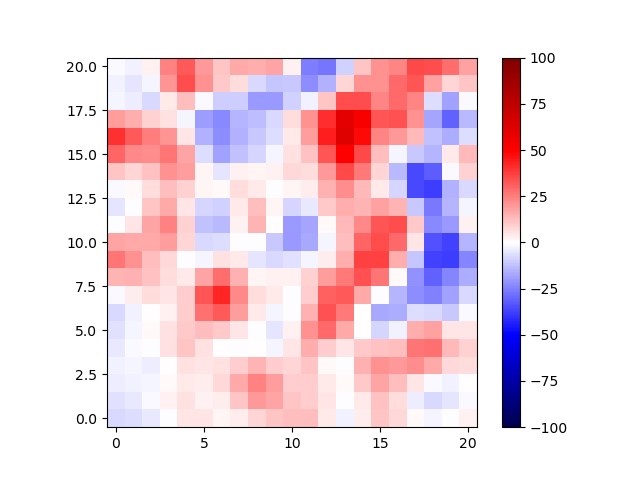

In [17]:
# Apply a gaussian filter with sigma of 1 to smooth out the multi-frequency curve
fig, ax = plt.subplots()
im = ax.imshow(gaussian_filter(error, 1),
           vmin=100,
           vmax=-100,
           cmap='seismic',
           origin="lower")
fig.colorbar(im, ax=ax)

In [18]:
# Error of the reach, exclusive reach, and overlap
report_data     = report.pivot_to_dim_cols(max_freq=1).values
vid_report_data = vid_report.pivot_to_dim_cols(max_freq=1).values

report_data[0, 0] = population_size - report_data[0, 0] 
vid_report_data[0, 0] = population_size - vid_report_data[0, 0] 

error_2 = np.round(100*(report_data - vid_report_data) / report_data, decimals=2)

print(f"Relative error in TOTAL REACH of both media is      % {error_2[0, 0]}")
print(f"Relative error in EXCLUSIVE REACH of MEDIUM I       % {error_2[1, 0]}")
print(f"Relative error in EXCLUSIVE REACH of MEDIUM II      % {error_2[0, 1]}")
print(f"Relative error in OVERLAP REACH of both media is    % {error_2[1, 1]}")

Relative error in TOTAL REACH of both media is      % -0.62
Relative error in EXCLUSIVE REACH of MEDIUM I       % 5.01
Relative error in EXCLUSIVE REACH of MEDIUM II      % -0.08
Relative error in OVERLAP REACH of both media is    % -1.99
